In [39]:
import polars as pl
import matplotlib.pyplot as plt

In [40]:
DATA_PATH = "../../data"

In [41]:
train = (
    pl.read_csv(f"{DATA_PATH}/train.csv")
    .with_columns(
        pl.col("prompt").str.json_decode(),
        pl.col("response_a").str.json_decode(),
        pl.col("response_b").str.json_decode(),
    )
    .with_columns( # 長さの情報を追加する
        pl.col("prompt").map_elements(lambda x: len(x), return_dtype=pl.Int64).alias("len_prompt"),
        pl.col("response_a").map_elements(lambda x: len(x), return_dtype=pl.Int64).alias("len_response_a"),
        pl.col("response_b").map_elements(lambda x: len(x), return_dtype=pl.Int64).alias("len_response_b"),
    )
    .with_columns( # 最後のレスポンスのみを取得する
        pl.col("prompt").map_elements(lambda x: x[-1], return_dtype=pl.String).alias("last_prompt"),
        pl.col("response_a").map_elements(lambda x: x[-1], return_dtype=pl.String).alias("last_response_a"),
        pl.col("response_b").map_elements(lambda x: x[-1], return_dtype=pl.String).alias("last_response_b"),
    )
    .with_columns( # 最後のレスポンスがNoneの場合を空文字にする、約60件程度
        pl.col("last_response_a").fill_null(""),
        pl.col("last_response_b").fill_null(""),
    )
    .with_columns( # labelを付与する
        pl.when(pl.col("winner_model_a") == 1)
        .then(0)
        .when(pl.col("winner_model_b") == 1)
        .then(1)
        .when(pl.col("winner_tie") == 1)
        .then(2)
        .alias("label"),
    )
    .select( # 元のprompt, responseを削除する
        pl.exclude(["prompt", "response_a", "response_b"])
    )
)

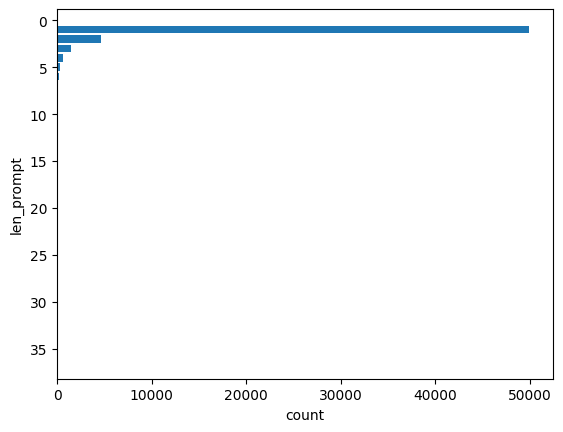

In [79]:
from collections import Counter
plt.barh(
    list(Counter(train["len_prompt"]).keys()),
    list(Counter(train["len_prompt"]).values())
)
plt.gca().invert_yaxis()  # y軸を逆にする

plt.xlabel("count")
plt.ylabel("len_prompt");

In [118]:
last_prompt_len = train["last_prompt"].str.split(by=" ").map_elements(lambda x: len(x), return_dtype=pl.Int64)
last_response_a_len = train["last_response_a"].str.split(by=" ").map_elements(lambda x: len(x), return_dtype=pl.Int64)
last_response_b_len = train["last_response_b"].str.split(by=" ").map_elements(lambda x: len(x), return_dtype=pl.Int64)

text_len = last_prompt_len + last_response_a_len + last_response_b_len

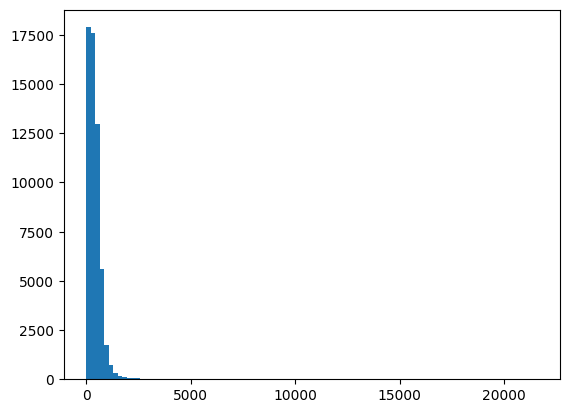

In [119]:
plt.hist(
    text_len , bins=100
);

In [125]:
def calc_len(text_len, thr_len: int):
    match_num = (text_len < thr_len).sum()
    all_num = len(text_len)
    return f"{match_num}/{all_num}={match_num/all_num:.2f}"

print(calc_len(text_len, 512))
print(calc_len(text_len, 1024))
print(calc_len(text_len, 1536))

40742/57477=0.71
55490/57477=0.97
56886/57477=0.99
